In [4]:
from epi_model import *

In [5]:
from simulation_helper import *

In [6]:
from simulation_manager import simulation_manager

In [7]:
from frozendict import frozendict as fzd

In [8]:
dfs, modelsets = {},{}

In [9]:
plt.style.use('seaborn-whitegrid')

In [10]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [11]:
defaults = {
    'R0_mean': 2.5,
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': 20
}

In [18]:
comparisons = {
    'VACCINATE_P': [0.05, 0.10, 0.20, 0.50],
    'R0_mean': [1, 2.5, 4],
    'INITIAL_INFECT': [5, 10, 20]
}

In [13]:
resultsets = [
    'HS2',
    'HS2_genargs',
]

resultset_print = {
    "HS2": "single argset",
    "HS2_genargs": "300 argsets",
}

In [14]:
strats = [
    #'rand',
    'friend',
    'friendHighDegRandTop5',
    'friendHighDegRandTop3',
    'friendHighDegNormalErr20',
    'friendHighDegNormalErr10',
    'friendHighDeg',
    'friendHighDegChain',
    'targeted',
]

strat_print = {
    'friend': "NR",
    'friendHighDegRandTop5': "NP(N=5)",
    'friendHighDegRandTop3': "NP(N=3)",
    'friendHighDegNormalErr20': "NP(ε=20)",
    'friendHighDegNormalErr10': "NP(ε=10)",
    'friendHighDeg': "NP",
    'friendHighDegChain': "NP(c)",
    'targeted': "D"
}

In [15]:
for name in resultsets:
    
    print(f'loading {name}')

    sim_m = simulation_manager()
    sim_m.load_models(name)

    rows = []
    for k,ms in sim_m.models.items():
        rows.append(sim_m.info(k))

    df = pd.DataFrame.from_records(rows)

    #df.head()
    
    dfs[name] = df
    modelsets[name] = sim_m

loading HS2
loading HS2_genargs


In [16]:
def results_plot(
    defaults,
    comparisons,
    resultsets,
    resultset_print,
    strats,
    strat_print,
    output_name,
):

    for ci,comp in enumerate(comparisons):

        display(Markdown(f"# {comp} = {comparisons[comp]}"))

        plt.figure(figsize=(10,16))
        plt.tight_layout()

        for ni, name in enumerate(resultsets):
            #plt.figure(figsize=(5,15 * len(comparisons[comp])/4))
            plt.subplot(1,3,ni+1)

            allvs = []
            allys = []
            mycs = comparisons[comp]
            for Vi,V in enumerate(mycs):

                sim_m = modelsets[name]
                df = dfs[name]

                svals = []
                for s in strats:
                    d = dict(defaults)
                    d[comp] = V
                    d['strat'] = s

                    inf = sim_m.info( fzd( d ) )
                    #print(inf['mean'], [x['mean'] for x in svals])

                    svals.append(inf)


                #[s['N']s['mean'] for s in svals]

                xs = np.array([1]+[ s['P_sus_inf_rel_rand'] for s in svals ])
                ys = np.linspace(0,0.8,len(svals)+1) + (len(mycs)-Vi)

                #plt.scatter(xs,ys)

                
                xerrs = np.array(
                    [(0,0)]+[
                        (lambda x:(x[1]-x[0],x[2]-x[1]))(s['P_sus_inf_rel_rand_BS']) 
                        for s in svals 
                    ]).T

                plt.errorbar(
                    xs, ys,
                    xerr = xerrs,
                    color='black'
                )
                
                plt.scatter(xs, ys, s=15, color='black')
                #print([s['min'] for s in svals])

                allvs.append( np.min(xs-xerrs)-0.05 )
                allvs.append( np.max(xs+xerrs)+0.05 )

                allys += list(ys)

            plt.title(f'{resultset_print[name]}')

            ytk = np.linspace(0,1.0,5)
            plt.xticks(ytk, [f'{t:0.0%}' for t in ytk], fontsize=10)

            if ni==1:
                plt.xlabel('Proportion of susceptible infected on average, relative to randomly vaccinating', fontsize=15)

            plt.xlim( min(allvs),max(allvs) )

            if ni==0:
                plt.yticks(
                    allys,
                    len(comparisons[comp])* (["R"]+[strat_print[s] for s in strats])
                )
            else:
                plt.yticks(
                    allys,
                    []
                )

            #plt.vlines([0.5, 0.75, 1], *plt.ylim())
            plt.grid('y')
            plt.xlim(0,1.15)

        plt.savefig(f'figures/{output_name}.{comp}.png', dpi=300)
        plt.show()

# VACCINATE_P = [0.05, 0.1, 0.2, 0.5]

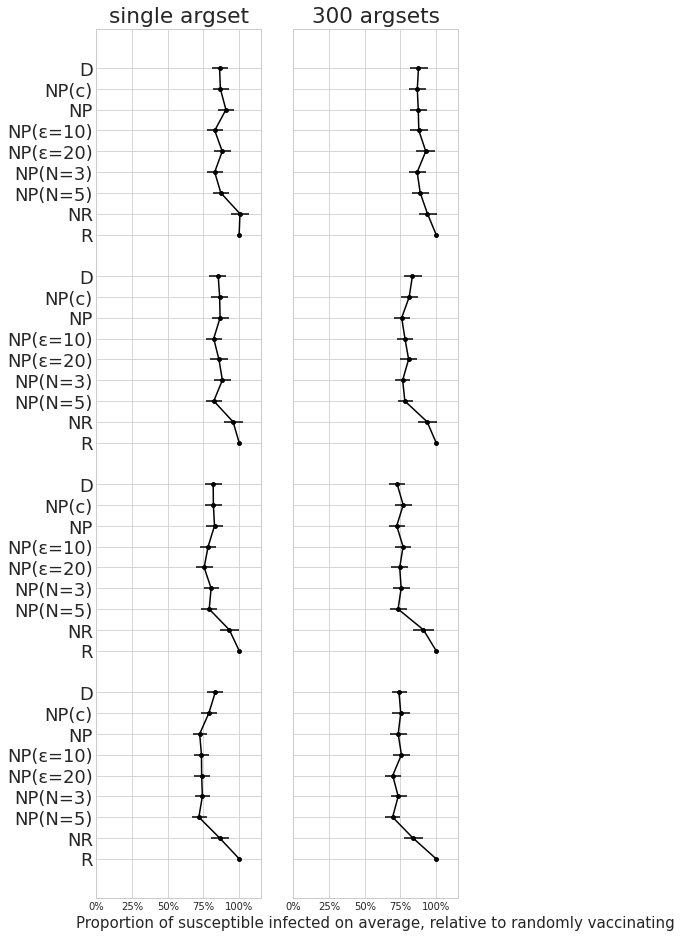

# R0_mean = [1, 2.5, 4]

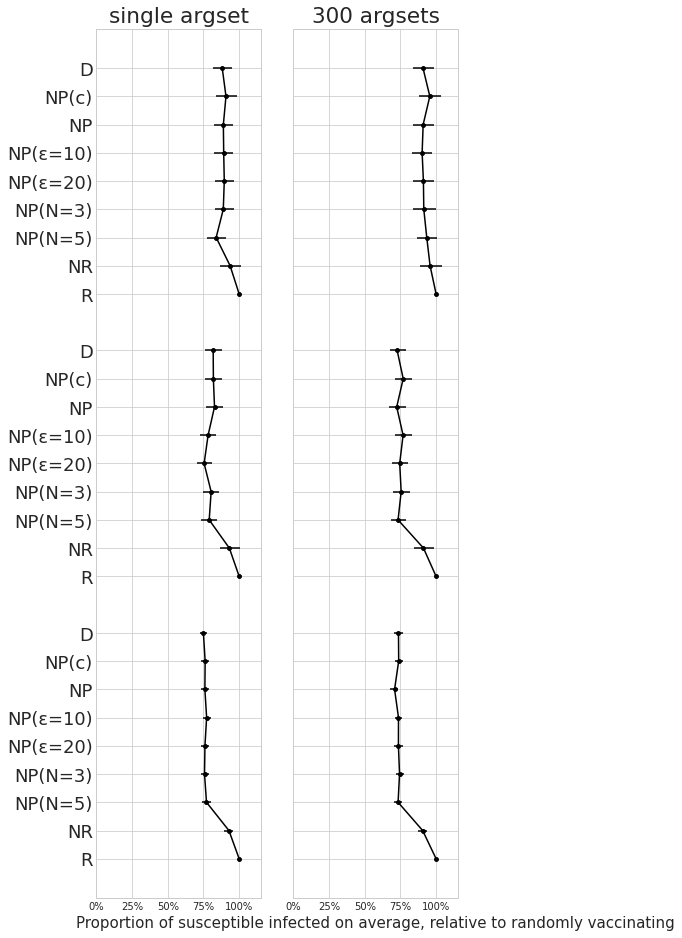

# INITIAL_INFECT = [5, 10, 20]

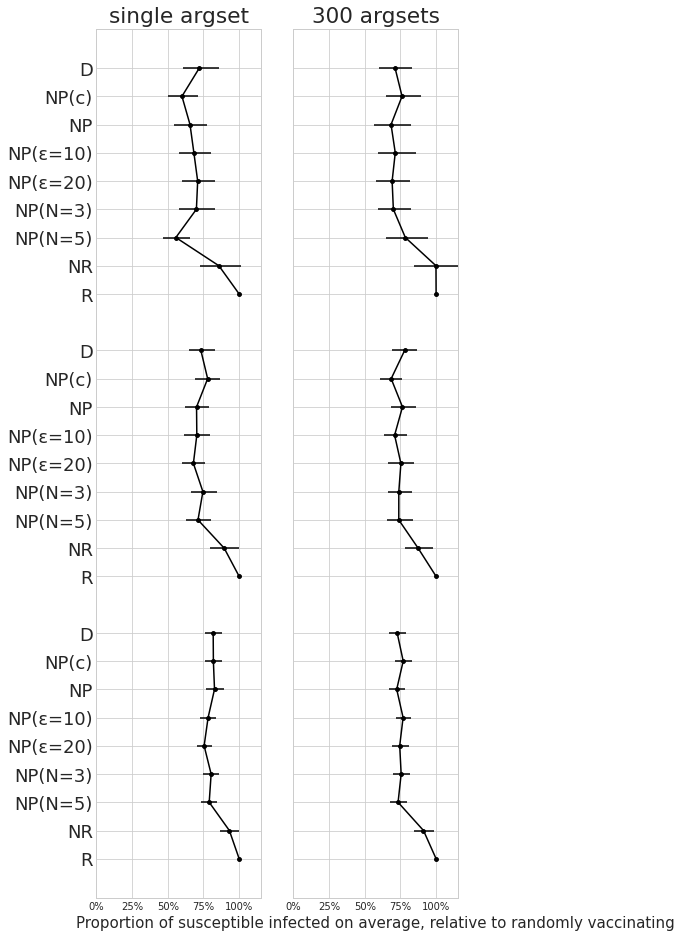

In [19]:
results_plot(
    defaults,
    comparisons,
    resultsets,
    resultset_print,
    strats,
    strat_print,
    output_name = 'single_vs_many_args'
)